In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

/Users/research/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

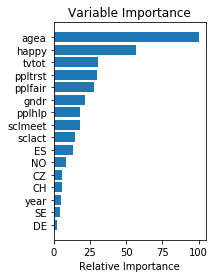

In [4]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [9]:
# Train a GBC ensamble with 500 trees, then measure the validation error at each stage 
# of training to find the optimal number of trees, then train another GBC ensamble using 
# the optimal number of trees
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

#Train GBC
gbc = ensemble.GradientBoostingClassifier(max_depth=2, n_estimators=500)
gbc.fit(X_train, y_train)

#measure validation errors
errors = [mean_squared_error(y_test, y_pred)
         for y_pred in gbc.staged_predict(X_test)]
bst_n_estimators = np.argmin(errors)

#train with optimal trees
gbc_best = ensemble.GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators)
gbc_best.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=268,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [10]:
predict_train = gbc_best.predict(X_train)
predict_test = gbc_best.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.045008183306055646
Percent Type II errors: 0.180987452264048

Test set accuracy:
Percent Type I errors: 0.053987730061349694
Percent Type II errors: 0.1901840490797546


There was a slight improvement in Type I errors in the test set, otherwise this model was just as poor as the inital model.

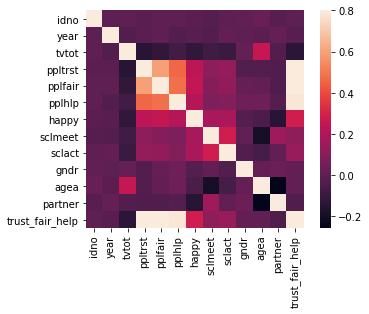

In [13]:
# trust, fair, help need to be combined
means = df[['ppltrst','pplfair','pplhlp']].mean(axis=0)
stds = df[['ppltrst','pplfair','pplhlp']].std(axis=0)
df['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

sns.heatmap(df.corr(), vmax=.8, square=True)
plt.show()

In [16]:
features = df.drop(['ppltrst', 'pplfair', 'pplhlp'], axis=1)
# features.head(2)

,cntry,idno,year,tvtot,happy,sclmeet,sclact,gndr,agea,partner,trust_fair_help
0,CH,5.0,6,3.0,8.0,5.0,4.0,2.0,60.0,1.0,0.191246
1,CH,25.0,6,6.0,9.0,3.0,2.0,2.0,59.0,1.0,0.020453


### Run the model a third time, with new features and gridsearch for the best parameters

In [17]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [21]:
from sklearn.grid_search import GridSearchCV

# use gridsearch for the best params
params = {'n_estimators': np.arange(44,501,76),
          'max_depth': [2,3,4,5],
          'learning_rate': [0.1, 0.05, 0.01]}

# Initialize and fit the model.
gbc_grid = ensemble.GradientBoostingClassifier()

grids = GridSearchCV(gbc_grid, params, cv=5)
grids.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([ 44, 120, 196, 272, 348, 424, 500]), 'max_depth': [2, 3, 4, 5], 'learning_rate': [0.1, 0.05, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [22]:
grids.grid_scores_, grids.best_params_, grids.best_score_

([mean: 0.67540, std: 0.09361, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 44},
  mean: 0.67062, std: 0.10671, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 120},
  mean: 0.67089, std: 0.10678, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 196},
  mean: 0.66926, std: 0.10475, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 272},
  mean: 0.66994, std: 0.10560, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 348},
  mean: 0.66926, std: 0.10505, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 424},
  mean: 0.66858, std: 0.10540, params: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500},
  mean: 0.67117, std: 0.10579, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 44},
  mean: 0.66858, std: 0.10423, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 120},
  mean: 0.66830, std: 0.10355, params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 196},
  

In [24]:
# Initiate and Train GBC
gbc = ensemble.GradientBoostingClassifier(max_depth=2, n_estimators=196, learning_rate=0.01)
gbc.fit(X_train, y_train)

predict_train = gbc.predict(X_train)
predict_test = gbc.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.028368794326241134
Percent Type II errors: 0.22940534642662302

Test set accuracy:
Percent Type I errors: 0.04539877300613497
Percent Type II errors: 0.22208588957055214


Now only the type I errors increased their accuracy with the validation set getting to about 95.5% accurate positive predictions. However, type II error increased and now there's only about 78% accurate for predicting people who don't live with a partner.